In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [619]:
train_original=pd.read_csv("Train_SU63ISt.csv")
test_original=pd.read_csv("Test_0qrQsBZ.csv")

In [620]:
submission=pd.read_csv('Sample_Submission_QChS6c3.csv')

In [621]:
train=train_original.copy()
test=test_original.copy()

In [622]:
print train.head()
print train.shape

   ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2
(18288, 3)


In [623]:
train.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [624]:
print test.head()
print test.shape

      ID          Datetime
0  18288  26-09-2014 00:00
1  18289  26-09-2014 01:00
2  18290  26-09-2014 02:00
3  18291  26-09-2014 03:00
4  18292  26-09-2014 04:00
(5112, 2)


In [625]:
train['Datetime']=pd.to_datetime(train['Datetime'],format="%d-%m-%Y %H:%M")
test['Datetime']=pd.to_datetime(test['Datetime'],format="%d-%m-%Y %H:%M")
test_original['Datetime']=pd.to_datetime(test_original['Datetime'],format="%d-%m-%Y %H:%M")
train_original['Datetime']=pd.to_datetime(train_original['Datetime'],format="%d-%m-%Y %H:%M")

In [626]:
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [627]:
def _weekend(input):
    if input==5 or input==6:
        return 1
    else:
        return 0

In [628]:
train['weekend']=train['day'].apply(_weekend)

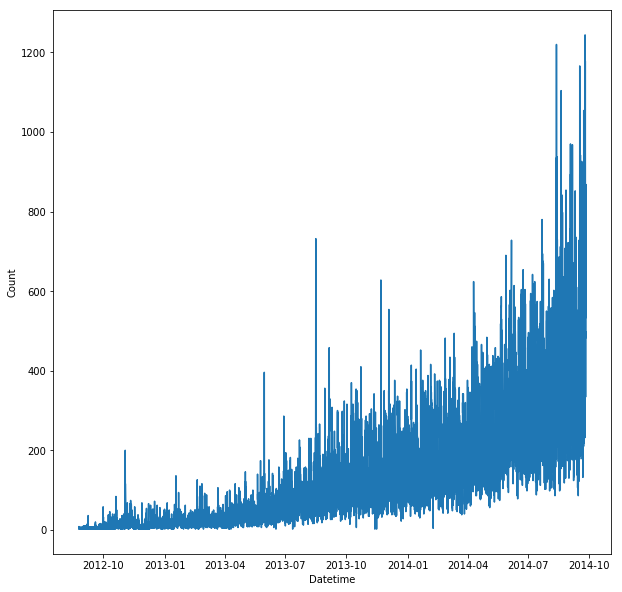

In [629]:
# Now visualise the time series
train.index=train['Datetime']
ts=train['Count']
plt.figure(figsize=(10,10))
plt.plot(ts,label='Passenger_Count')
plt.xlabel('Datetime')
plt.ylabel('Count')
plt.show()

In [630]:
# Exploratory Analysis

C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
  


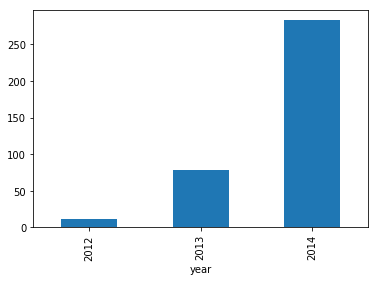

In [631]:
# It's increasiong year by year
pd.groupby(train['Count'],by=train['year']).mean().plot('bar')

C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
  


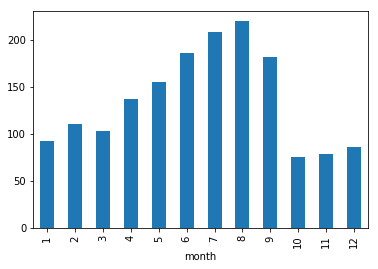

In [632]:
# Monthly analysis - It can be inference that peak is from June to September.But we can't make inference because in year 2014, we are provided eith data upto Sepetember
pd.groupby(train['Count'],train['month']).mean().plot('bar')


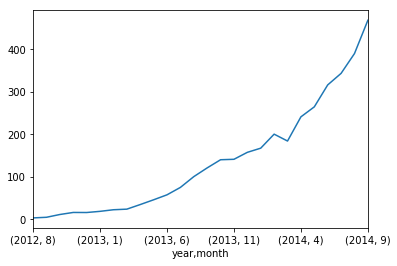

In [633]:
# Now we can inference that it is continuously inscreasing
train.groupby(['year','month'])['Count'].mean().plot()

C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
  


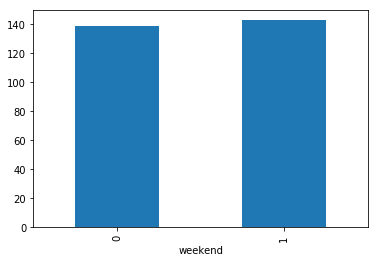

In [634]:
# Weekdays are more prone to rush
pd.groupby(train['Count'],train.weekend).mean().plot('bar')

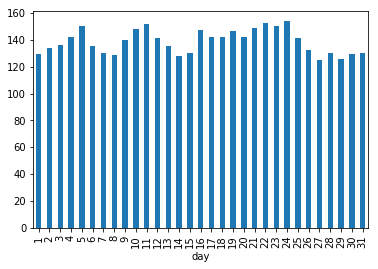

In [635]:
# On the basis of date of month-Can't be inference anything from it.
train.groupby('day')['Count'].mean().plot('bar')

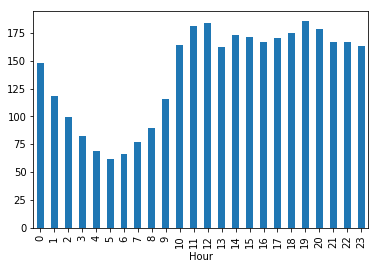

In [636]:
#Hourly basis- Rush is at peak at 11-12am and again at 7pm in evening
train.groupby('Hour')['Count'].mean().plot('bar')

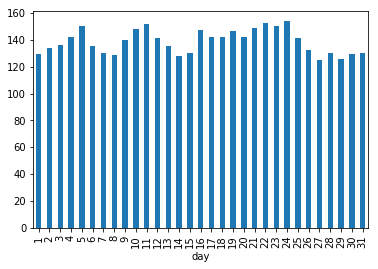

In [637]:
#Day of the week-Can be inferred that weekdays have more rush than weekends
train.groupby('day')['Count'].mean().plot('bar')

In [638]:
train=train.drop('ID',1)

In [639]:
train['Timestamp']=pd.to_datetime(train['Datetime'],format="%d-%m-%Y %H:%M")
train.index=train['Timestamp']

In [640]:
hourly=train.resample('H').mean()
daily=train.resample('D').mean()
weekly=train.resample('W').mean()
monthly=train.resample('M').mean()

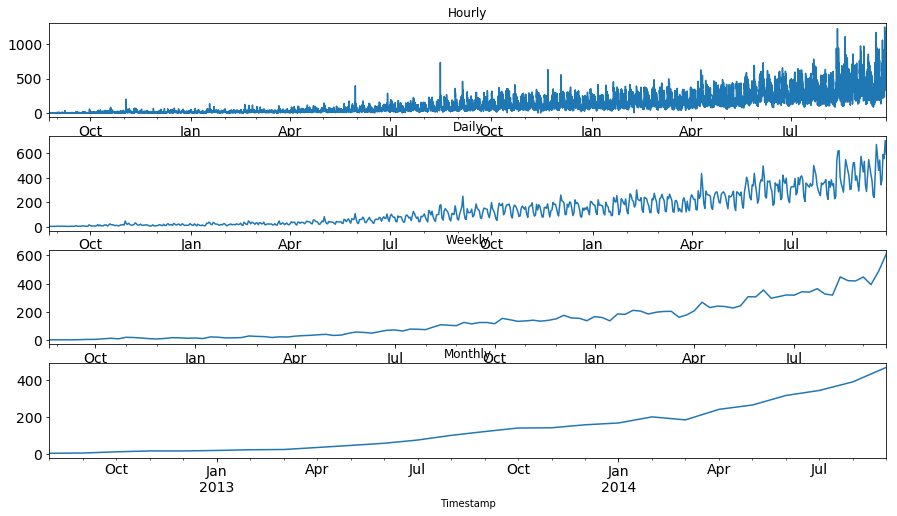

In [641]:
fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

In [642]:
# It can be seen that daily,weekly and monthly are more stable.

In [643]:
test=test.drop('ID',1)
test.Timestamp=pd.to_datetime(test['Datetime'],format="%d-%m-%Y %H:%M")
test.index=test.Timestamp

In [644]:
test=test.resample('D').mean()

In [645]:
train=train.resample('D').mean()

In [646]:
# Splitting the dataset to train and validation dataset.

In [647]:
Train=train.ix['2012-08-25':'2014-06-24']
valid=train.ix['2014-06-24':'2014-09-25']

C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


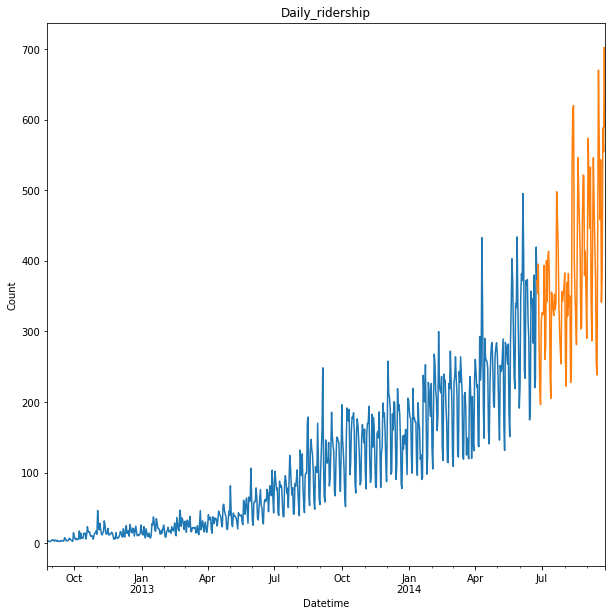

In [648]:
Train.Count.plot(figsize=(10,10),title='Daily_ridership',label='Train')
valid.Count.plot(figsize=(10,10),title='Daily_ridership',label='Valid')
plt.xlabel("Datetime")
plt.ylabel("Count")
plt.show()

In [649]:
#Stationarize time series

In [650]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


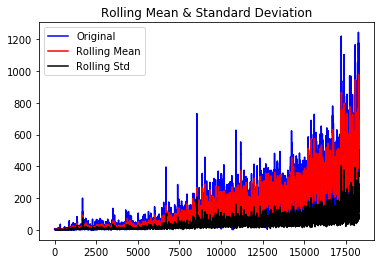

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (5%)               -2.861698
Critical Value (1%)               -3.430709
Critical Value (10%)              -2.566854
dtype: float64


In [651]:
test_stationarity(train_original['Count'])

In [652]:
ts=Train['Count']
vs=valid['Count']

In [653]:
ts_log=np.log(ts)
vs_log=np.log(vs)
tr_log=ts_log.append(vs_log)

C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


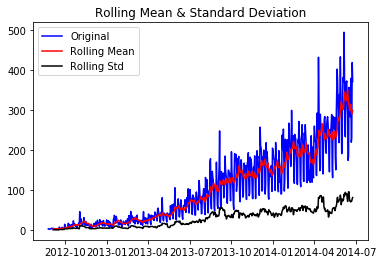

Results of Dickey-Fuller Test:
Test Statistic                   1.387308
p-value                          0.997056
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (5%)             -2.866011
Critical Value (1%)             -3.440482
Critical Value (10%)            -2.569151
dtype: float64


In [654]:
test_stationarity(ts)

In [655]:
ts_log_diff=ts_log-ts_log.shift()

In [656]:
ts_log_diff.dropna(inplace=True)

C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


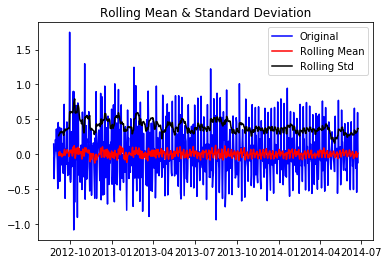

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (5%)           -2.866011e+00
Critical Value (1%)           -3.440482e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [657]:
test_stationarity(ts_log_diff)

In [658]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=25)
lag_pacf = pacf(ts_log_diff, nlags=25, method='ols')

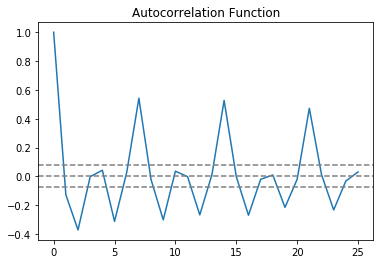

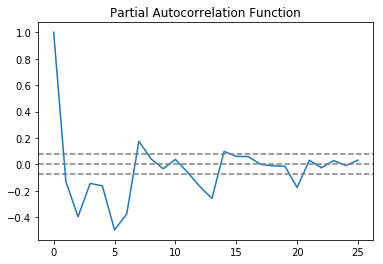

In [659]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()


In [660]:
#p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.
#q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

In [661]:
from statsmodels.tsa.arima_model import ARIMA

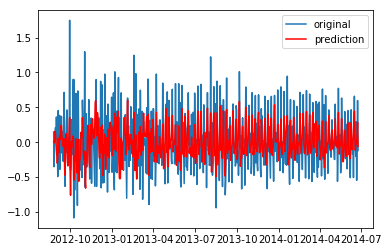

In [662]:
model=ARIMA(ts_log,order=(2,1,2))
results_AR=model.fit(disp=-1)
plt.plot(ts_log_diff,label='original')
plt.plot(results_AR.fittedvalues,color='red',label='prediction')
plt.legend(loc='best')
plt.show()

In [663]:
AR_predict=results_AR.predict(start="2014-06-25",end='2015-04-26')

In [664]:
valid_predict=AR_predict["2014-06-25":'2014-09-25']

In [665]:
valid_predict=valid_predict.cumsum().shift().fillna(0)
valid_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
valid_predict1=valid_predict1.add(valid_predict,fill_value=0)
valid_predict = np.exp(valid_predict1)

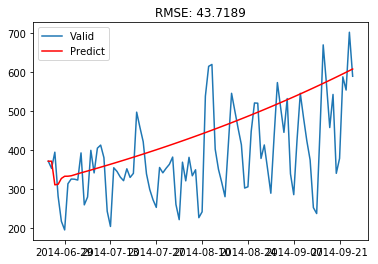

In [666]:
plt.plot(valid['Count'], label = "Valid")
plt.plot(valid_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(valid_predict, valid['Count']))/valid.shape[0]))
plt.show()

In [667]:
test_predict=AR_predict['2014-09-26':'2015-04-26']

In [668]:
test_predict=test_predict.cumsum()

In [669]:
test_predict1=pd.Series(vs_log.ix[-1],index=test.index)

C:\Users\PIYUSH\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [670]:
test_predict1=test_predict1.add(test_predict)

In [671]:
prediction_ar=np.exp(test_predict1)

In [672]:
test['prediction']=prediction_ar

In [673]:
# Calculating the hourly ratio of count
train_original['ratio']=train_original['Count']/train_original['Count'].sum()

# Grouping the hourly ratio
temp=train_original.groupby(['Hour'])['ratio'].sum()

# Groupby to csv format
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv')

temp2=pd.read_csv("GROUPby.csv")
temp2=temp2.drop('Hour.1',1)

# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [674]:
submission['ID']=test_original['ID']

In [675]:
submission['Count']=prediction['Count']

In [676]:
submission.to_csv("arima_time_series3.csv",index=False)